In [2]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import opinion_lexicon
import pandas as pd
import textstat  # Для Flesch-Kincaid
import scipy.sparse as sp

# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')

# Инициализация лемматизатора и стоп-слов
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Функция для предобработки текста
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text

# Функция для загрузки и предобработки данных
def load_and_preprocess_data(directory):
    reviews = []
    sentiments = []
    ratings = []

    for label in ['pos', 'neg']:
        folder = os.path.join(directory, label)
        for filename in os.listdir(folder):
            if filename.endswith('.txt'):
                with open(os.path.join(folder, filename), 'r', encoding='utf-8') as f:
                    review = f.read()
                    preprocessed_review = preprocess_text(review)
                    reviews.append(preprocessed_review)

                    rating = int(filename.split('_')[1].split('.')[0])
                    ratings.append(rating)

                    if rating >= 7:
                        sentiments.append(1)  # Положительный отзыв
                    else:
                        sentiments.append(0)  # Негативный отзыв

    return reviews, sentiments, ratings

# Функция для нормализации меток рейтингов
def normalize_ratings(ratings):
    normalized = []
    for r in ratings:
        if r <= 4:
            normalized.append(r - 1)  # 1 -> 0, 2 -> 1, 3 -> 2, 4 -> 3
        else:
            normalized.append(r - 3)  # 7 -> 4, 8 -> 5, 9 -> 6, 10 -> 7
    return np.array(normalized)

# Функция для извлечения признаков
def extract_features(reviews):
    # Полярность текста
    polarities = [TextBlob(review).sentiment.polarity for review in reviews]

    # Частота положительных и отрицательных слов
    positive_words = set(opinion_lexicon.positive())
    negative_words = set(opinion_lexicon.negative())

    pos_counts = []
    neg_counts = []

    for review in reviews:
        tokens = word_tokenize(review)
        pos_count = sum(1 for word in tokens if word in positive_words)
        neg_count = sum(1 for word in tokens if word in negative_words)
        pos_counts.append(pos_count)
        neg_counts.append(neg_count)

    # Частота употребления прилагательных и наречий
    adj_counts = []
    adv_counts = []

    for review in reviews:
        tokens = word_tokenize(review)
        pos_tags = pos_tag(tokens)
        adj_count = sum(1 for word, tag in pos_tags if tag.startswith('JJ'))  # Adjective
        adv_count = sum(1 for word, tag in pos_tags if tag.startswith('RB'))  # Adverb
        adj_counts.append(adj_count)
        adv_counts.append(adv_count)

    # Элементы структуры текста: количество восклицательных и вопросительных знаков
    exclamation_counts = [review.count('!') for review in reviews]
    question_counts = [review.count('?') for review in reviews]

    # Сложность текста: Flesch-Kincaid readability score
    def flesch_reading_ease(text):
        return textstat.flesch_reading_ease(text)

    readability_scores = [flesch_reading_ease(review) for review in reviews]

    # Создание DataFrame с признаками
    features_df = pd.DataFrame({
        'Polarity': polarities,
        'Pos_Count': pos_counts,
        'Neg_Count': neg_counts,
        'Adj_Count': adj_counts,
        'Adv_Count': adv_counts,
        'Exclamation_Count': exclamation_counts,
        'Question_Count': question_counts,
        'Readability_Score': readability_scores
    })

    return features_df

# Укажите путь к вашим локальным папкам
train_dir = "C:\\Users\\Vito\\Jupyter\\Case Lab\\a\\train"  # Укажите путь к папке с обучающей выборкой
test_dir = "C:\\Users\\Vito\\Jupyter\\Case Lab\\a\\test"    # Укажите путь к папке с тестовой выборкой

# Загрузка и предобработка данных
train_reviews, train_sentiments, train_ratings = load_and_preprocess_data(train_dir)
test_reviews, test_sentiments, test_ratings = load_and_preprocess_data(test_dir)

# Нормализация рейтингов
train_ratings_normalized = normalize_ratings(train_ratings)
test_ratings_normalized = normalize_ratings(test_ratings)

# Векторизация текста с использованием TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_reviews)
X_test_tfidf = tfidf.transform(test_reviews)

# Извлечение признаков
train_features = extract_features(train_reviews)
test_features = extract_features(test_reviews)

# Объединение TF-IDF и новых признаков
import scipy.sparse as sp

X_train_combined = sp.hstack([X_train_tfidf, train_features.values])
X_test_combined = sp.hstack([X_test_tfidf, test_features.values])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vito/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Vito/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Vito/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vito/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Vito/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [1]:
# --- Модель 1: Логистическая регрессия для классификации sentiments ---
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_combined, train_sentiments)

# Предсказания и оценка модели
sentiments_pred = log_reg.predict(X_test_combined)
sentiment_accuracy = accuracy_score(test_sentiments, sentiments_pred)
print(f"Logistic Regression Sentiment Accuracy: {sentiment_accuracy:.4f}")

NameError: name 'LogisticRegression' is not defined

RidgeClassifier Rating Accuracy: 0.3983


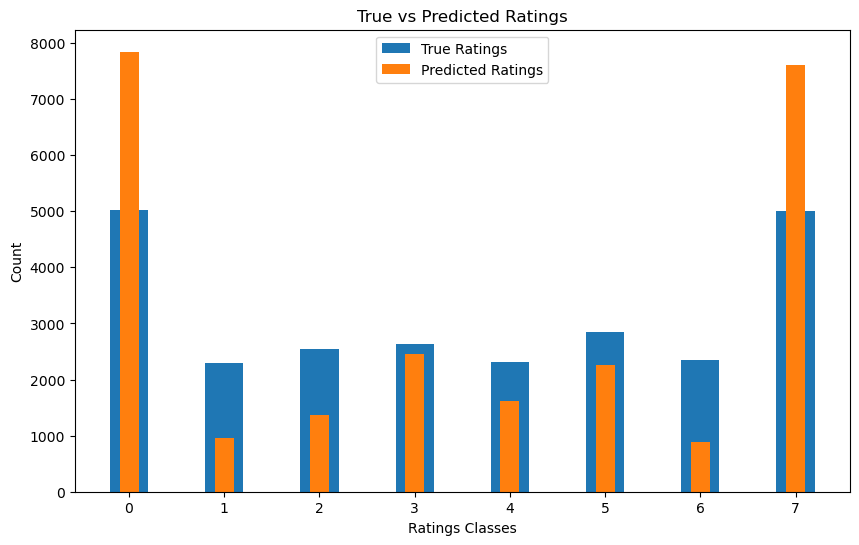

In [6]:
# --- Модель 2: RidgeClassifier для предсказания рейтинга ---
ridge = RidgeClassifier(alpha = 1)
ridge.fit(X_train_combined, train_ratings_normalized)

# Предсказания и оценка модели
ratings_pred = ridge.predict(X_test_combined)
rating_accuracy = accuracy_score(test_ratings_normalized, ratings_pred)
print(f"RidgeClassifier Rating Accuracy: {rating_accuracy:.4f}")

# --- Построение диаграммы ---
unique_classes = np.unique(test_ratings_normalized)

plt.figure(figsize=(10, 6))

# Построение столбцов для реальных классов
plt.bar(unique_classes, np.bincount(test_ratings_normalized), width=0.4, label='True Ratings', align='center')

# Построение столбцов для предсказанных классов
plt.bar(unique_classes, np.bincount(ratings_pred), width=0.2, label='Predicted Ratings', align='center')

plt.xlabel('Ratings Classes')
plt.ylabel('Count')
plt.title('True vs Predicted Ratings')
plt.legend()
plt.show()

In [11]:
import joblib
# Сохранение первой модели и TF-IDF
joblib.dump(log_reg, 'C:\\Users\\Vito\\Jupyter\\Case Lab\\logistic_model.pkl')
joblib.dump(tfidf, 'C:\\Users\\Vito\\Jupyter\\Case Lab\\tfidf_vectorizer.pkl')
# Сохранение второй модели
joblib.dump(ridge, 'C:\\Users\\Vito\\Jupyter\\Case Lab\\ridge_model.pkl')

['C:\\Users\\Vito\\Jupyter\\Case Lab\\ridge_model.pkl']